In [1]:
import sys
import pandas as pd
import os
import numpy as np

sys.path.insert(0, '../')
from glmhmm.glm_hmm import *
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Load Data(file(s) -> t, x, y)

In [2]:
# I add a new argument exclude_ignore.
def data_for_psy(efile, nprev=3, exclude_ignore = True):
    events = pd.read_csv( efile )
    nTrials = len(events['id'])
    
    stim = np.zeros( (nTrials,1) )
    choice = np.zeros( nTrials )
    prev_choice = np.zeros((nTrials,nprev))
    prev_stim = np.zeros((nTrials, 1))
    
    stim[events['trial_instruction']=='left']=1

    # right: 0, left:1, ignore:2
    choice[np.where((events['trial_instruction']=='left') & (events['outcome']=='hit'))[0]] = 1
    choice[np.where((events['trial_instruction']=='right') & (events['outcome']=='miss'))[0]] = 1
    choice[events['outcome']=='ignore']=2

    prev_stim[1:] = stim[:-1]
    for k in range(1,nprev+1):
        prev_choice[k:,k-1] = choice[:-k]
    
    ignore_ids = np.where(choice==2)[0]
    ex_ids = []
    for k in range(0,nprev+1):
        ex_ids.append(k-1)

        # if the ignore is included, then don't exclude the following ids
        if (exclude_ignore):
            for jj in ignore_ids:
                ex_ids.append(jj+k)
            
    use_ids = [jj for jj in range(nTrials) if jj not in ex_ids]

    D = {
        'y': np.int_(choice[use_ids]), 
        'inputs': {
            'stim': np.int_(stim[use_ids, :]), 
            'prev_choice': np.int_(prev_choice[use_ids, :]), 
            'prev_stim': np.int_(prev_stim[use_ids, :])  
        }
    }
    return D, use_ids

In [3]:
# Get the t,x,y from a file
# return a matrix of the format [t| x |y]
def Dataloader_sess(file, nprev=3, exig=True):
    
    D, use_id = data_for_psy(file, nprev = nprev, exclude_ignore = exig)
    
    # t = np.array(use_id).reshape(-1, 1)
    t = np.array(range(1, len(D['y']) + 1)).reshape(-1,1)
    x = np.concatenate([np.ones((len(D['y']), 1)), D['inputs']['stim'], D['inputs']['prev_choice'], D['inputs']['prev_stim']], axis = 1)
    y = D['y'].reshape(-1,1)

    # matrix = t| x |y
    matrix = np.concatenate([t,x,y], axis = 1)
    
    return matrix

In [4]:
# Get the concatenated t,x,y from all the csv files in a given folder
# return a matrix of the format [t| x |y]
def Dataloader_ani(directory, nprev = 3, exig = True):
    # Loop through all files in the directory
    matrix_list = []
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            submatrix = Dataloader_sess(directory + '/' +  filename, nprev = nprev, exig = exig)
            matrix_list.append(submatrix)
    matrix = np.concatenate(matrix_list, axis = 0)
    matrix[:,0] = np.arange(1, len(matrix) + 1)
    return matrix

In [5]:
file = '../example_data/sub_455219/sub-455219_ses-20190805T152117_trial_events.csv'
# file = '../example_data/sub_455220/sub-455220_ses-20190731T151805_trial_events.csv'
# file = '../example_data/sub_480928/sub-480928_ses-20210128T133949_trial_events.csv'
df = pd.read_csv(file)
df

,id,start_time,stop_time,trial,photostim_onset,photostim_power,photostim_duration,trial_uid,task,task_protocol,...,go_start_times,go_stop_times,left_lick_times,photostim_start_times,photostim_stop_times,presample_start_times,presample_stop_times,right_lick_times,sample_start_times,sample_stop_times
0,0,0.0000,4.2505,1,NaN,NaN,NaN,1,audio delay,1,...,3.2469,[],[],[],[],0.5000,1.3969,3.7505,1.3969,2.0469
1,1,6.0362,11.0627,2,NaN,NaN,NaN,2,audio delay,1,...,9.1057,10.6057,"[9.5227, 9.7149, 9.8981, 10.0763, 10.2694, 10....",[],[],6.5362,7.2557,[],7.2557,7.9057
2,2,14.4301,19.7931,3,NaN,NaN,NaN,3,audio delay,1,...,18.1472,19.6472,"[16.1972, 18.2531, 18.3861, 18.5678, 18.7463, ...",[],[],14.9301,15.8211,[],"[15.8211, 16.2972]","[16.4711, 16.9472]"
3,3,21.6880,26.0036,4,NaN,NaN,NaN,4,audio delay,1,...,25.3289,[],"[23.1434, 23.3789]",[],[],22.1880,23.0483,"[22.1132, 22.3215, 22.5577, 25.5036, 25.7631, ...","[23.0483, 23.2434, 23.4789]","[23.6983, 23.8934, 24.1289]"
4,4,27.7900,34.1852,5,NaN,NaN,NaN,5,audio delay,1,...,32.5261,34.0261,"[29.7056, 29.9507, 29.9707, 31.2261, 32.6452, ...",[],[],28.2900,29.1176,[],"[29.1176, 29.8056, 30.0507]","[29.7676, 30.4556, 30.7007]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
556,556,3782.4033,3787.1798,557,NaN,NaN,NaN,557,audio delay,1,...,3785.5037,3787.0037,"[3785.6398, 3785.758, 3785.8952, 3786.054, 378...",[],[],3782.9033,3783.6537,[],3783.6537,3784.3037
557,557,3789.4584,3794.3493,558,NaN,NaN,NaN,558,audio delay,1,...,3792.6268,3794.1268,[],[],[],3789.9584,3790.7768,"[3792.8093, 3792.9349, 3793.0971, 3793.2334, 3...",3790.7768,3791.4268
558,558,3796.6298,3801.6103,559,NaN,NaN,NaN,559,audio delay,1,...,3799.8264,3801.3264,[],[],[],3797.1298,3797.9764,"[3800.0703, 3800.2427, 3800.3874, 3800.5254, 3...",3797.9764,3798.6264
559,559,3803.8857,3808.9316,560,NaN,NaN,NaN,560,audio delay,1,...,3807.1176,3808.6176,[],[],[],3804.3857,3805.2676,"[3807.3916, 3807.5498, 3807.7074, 3807.8444, 3...",3805.2676,3805.9176


In [6]:
folder = "../example_data/sub_455219"
# folder = "../example_data/sub_479121"

# Fit GLM-HMM

In [7]:
# Get the index of the last non-NaN value for each row
# 
# The loglikelihood returned from fit() is of shape (250,)
# where 250 is the maximum number of EM iterations
#
# So this function can help us get the loglikelihood of the final parameters
def find_last_non_nan_elements(matrix):
    last_non_nan_values = np.full(matrix.shape[0], np.nan)
    
    for i, row in enumerate(matrix):
        # Get the index of the last non-NaN value
        last_non_nan_idx = np.where(~np.isnan(row))[0]
        if last_non_nan_idx.size > 0:
            last_non_nan_values[i] = row[last_non_nan_idx[-1]]
    
    return last_non_nan_values

# Cross Validation
#
# Given a file/folder, number of p.c., whether exclude ignore, and number of folder(default 10)
# return train loglikelihood, test loglikelihood, A, w for all 10 train-test pairs, and train size and test size
#
# The train set of all the folds don't overlap each other
# For each train set, initialize the model twice/three times, and choose the one with the best train loglikelihood
# This is because EM alg doesn't guarantee to find the global minimum
def CrossValidation(path, nprev, exig, num_latent, num_folds = 10):
    # Get data from the given path
    if os.path.isfile(path):
        data = Dataloader_sess(path, nprev = nprev, exig = exig)
    elif os.path.isdir(path):
        data = Dataloader_ani(path, nprev = nprev, exig = exig)
    else:
        raise ValueError("The input is neither a file or a folder")
        
    # Model parameters
    N = len(data) - len(data)//num_folds # number of data/time points
    train_size = N
    test_size = len(data)//num_folds
    K = num_latent # number of latent states
    D = data.shape[1] - 2 # number of GLM inputs (regressors)
    if exig:
        C = 2 # number of observation classes
        prob = "bernoulli"
    else:
        C = 3 # number of observation classes
        prob = "multinomial"
        
    # store values for cross validation
    lls_train = np.zeros(num_folds)
    lls_test = np.zeros(num_folds)
    A_all = np.zeros((num_folds,K,K))
    w_all = np.zeros((num_folds,K,D,C))
    
    # Perform cross-validation
    fold_size = len(data) // num_folds
    for i in range(num_folds):
        start_idx = i * fold_size
        end_idx = (i + 1) * fold_size
        
        # Split data into train and test sets
        test_data = data[start_idx:end_idx]
        if end_idx < len(data):
            train_data = np.concatenate((data[:start_idx], data[end_idx:]), axis=0)
        else:
            train_data = data[:start_idx]

        X_train = train_data[:,1:-1]
        y_train = train_data[:,-1:]
        X_test = test_data[:,1:-1]
        y_test = test_data[:,-1:]

        # Fit GLM on trainset
        model = GLMHMM(N,D,C,K,observations=prob) # set up a new GLM-HMM
        # try different initializations and choose the best one
        init = 3#2
        ll_array = np.zeros(init)
        A_list=[]
        w_list=[]
        for j in range(init):
            A_init,w_init,pi_init = model.generate_params() # initialize the model parameters
            ll, A, w, pi0 = model.fit(y_train,X_train,A_init,w_init) # fit the model on trainset
            ll = find_last_non_nan_elements(ll.reshape(1, -1))
            ll_array[j] = ll[0]
            A_list.append(A)
            w_list.append(w)
            print(f"Init {j+1} Complete")
        lls_train[i],A_all[i,:,:],w_all[i,:,:,:] = ll_array[np.argmax(ll_array)], A_list[np.argmax(ll_array)], w_list[np.argmax(ll_array)]
        # Testset
        GLMHMM.n = test_size
        # convert inferred weights into observation probabilities for each state
        phi = np.zeros((len(X_test),K,C))
        for k in range(K):
            phi[:,k,:] = model.glm.compObs(X_test,w_all[i,k,:,:])
            
        # compute inferred log-likelihoods
        lls_test[i],_,_,_ = model.forwardPass(y_test,A_all[i,:,:],phi)
        print('train ll', lls_train[i])
        print('test ll',lls_test[i])
        
        print('Cross Validation %s complete' %(i+1))
    return lls_train, lls_test, A_all, w_all, train_size, test_size

In [8]:
lls_train, lls_test, A_all, w_all, train_size, test_size = CrossValidation(file, 3, True, 4)

Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -345.7048311869154
test ll -38.63049151844148
Cross Validation 1 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -298.8951703212815
test ll -35.1356708251742
Cross Validation 2 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -320.33250768061237
test ll -35.24206316193704
Cross Validation 3 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -302.2501380732957
test ll -33.13277887298756
Cross Validation 4 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -300.73715745229515
test ll -33.47742739351023
Cross Validation 5 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -336.79434943779705
test ll -37.92768214138351
Cross Validation 6 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -307.2877700555691
test ll -32.99409669021487
Cross Validation 7 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -302.3460013865464
test 

In [9]:
# averaged marginal loglikelihood across time
np.mean(lls_train)/train_size, np.mean(lls_test)/test_size

(-0.6362030404002458, -0.6414173283927658)

In [10]:
lls_train, lls_test, A_all, w_all, train_size, test_size = CrossValidation(folder, 3, True, 4)

Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -1509.8586017193452
test ll -168.42108105129662
Cross Validation 1 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -1397.9835603762408
test ll -156.96559425198146
Cross Validation 2 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -1463.5171340328604
test ll -164.8964963778787
Cross Validation 3 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -1439.106042567566
test ll -166.91110909223596
Cross Validation 4 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -1392.208547541974
test ll -157.18807665786707
Cross Validation 5 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -1500.2325324568274
test ll -166.90212834331845
Cross Validation 6 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -1366.2810086779098
test ll -153.18855068158874
Cross Validation 7 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -1307.049089182

In [11]:
# averaged marginal loglikelihood across time
np.mean(lls_train)/train_size, np.mean(lls_test)/test_size

(-0.6373878174509633, -0.6410692405708233)

In [12]:
np.exp(-0.665)

0.5142735277066319

In [13]:
# Grid Search on number of previous choice and number of latent states
# 
# Given a file/folder, whether exclude the ignore, the largest chosen p.c. and l.s.
# return optimal pc and ls(selected based on test loglikelihood), avg test and train ll,
# std test and train ll (avg and std across folds), train size and test size
# 
# The chosen num of pv are 0,1,2,...,P
# The chosen num of ls are 1,2,...,L
# Consider all the possible combinations(configurations)
# Notice that the returned opt params may not the right one. 
# The better way is to look at the visualization.
def GridSearch(path, exig, P=4, L=7):
    nprevs = np.arange(0,P+1)
    nums_latent = np.arange(1,L+1)
    avg_testll_matrix = np.zeros((P + 1,L))
    avg_trainll_matrix = np.zeros((P+1,L))
    std_testll_matrix = np.zeros((P+1, L))
    std_trainll_matrix = np.zeros((P+1,L))
    for nprev in nprevs:
        for num_latent in nums_latent:
            # lls_train:n, A_all:nxKxK, w_all:nxKxDxC, lls_test:n, where n is the num_fold
            print()
            print("nprev", nprev, "num_latent", num_latent)
            lls_train, lls_test, A_all, w_all, train_size, test_size = CrossValidation(path=path, 
                                                                                       nprev=nprev, exig=exig, num_latent=num_latent)
            
            avg_testll_matrix[nprev,num_latent-1] = np.mean(lls_test)
            avg_trainll_matrix[nprev,num_latent-1] = np.mean(lls_train)
            std_testll_matrix[nprev,num_latent-1] = np.std(lls_test)
            std_trainll_matrix[nprev,num_latent-1] = np.std(lls_train)

            # Select the optimal configuration using validation/test loglikelihood
            argminx,argminy = np.unravel_index(np.argmax(avg_testll_matrix), avg_testll_matrix.shape)
            opt_nprev = argminx
            opt_latent = argminy + 1
    return opt_nprev, opt_latent, avg_testll_matrix, avg_trainll_matrix, std_testll_matrix, std_trainll_matrix, train_size, test_size

In [14]:
# exclude ignore
opt_np, opt_lt, avg_test, avg_train, std_test, std_train, train_sz, test_sz = GridSearch(file,#folder,
                                                                                         True)


nprev 0 num_latent 1
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -390.61736848917246
test ll -37.96929822641863
Cross Validation 1 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -322.2331889552576
test ll -34.2600866301829
Cross Validation 2 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -351.57316762713504
test ll -37.37786449230296
Cross Validation 3 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -368.11088882253864
test ll -39.28530498583909
Cross Validation 4 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -303.75010946549696
test ll -30.96012674627409
Cross Validation 5 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -326.030362561154
test ll -36.14708191975497
Cross Validation 6 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -314.8511610501401
test ll -34.12927598074975
Cross Validation 7 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -4

KeyboardInterrupt: 

In [ ]:
opt_np, opt_lt, avg_test, avg_train, std_test, std_train, train_sz, test_sz

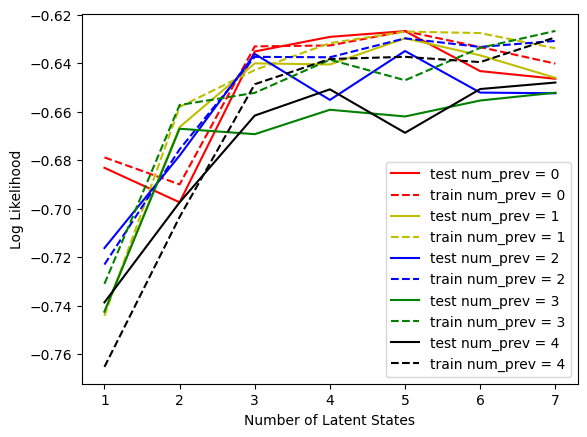

In [ ]:
num_np, num_numlt = avg_test.shape
colors = ['r','y','blue','green', 'black', 'm', 'gold', 'gray','pink']
for rowid in range(num_np):
    x = range(1,num_numlt + 1)
    plt.plot(x, avg_test[rowid]/test_sz, color = colors[rowid],label = f"test num_prev = {rowid}")
    plt.plot(x, avg_train[rowid]/train_sz, '--',color = colors[rowid], label = f"train num_prev = {rowid}")
plt.ylabel("Log Likelihood")
plt.xlabel("Number of Latent States")
plt.legend()

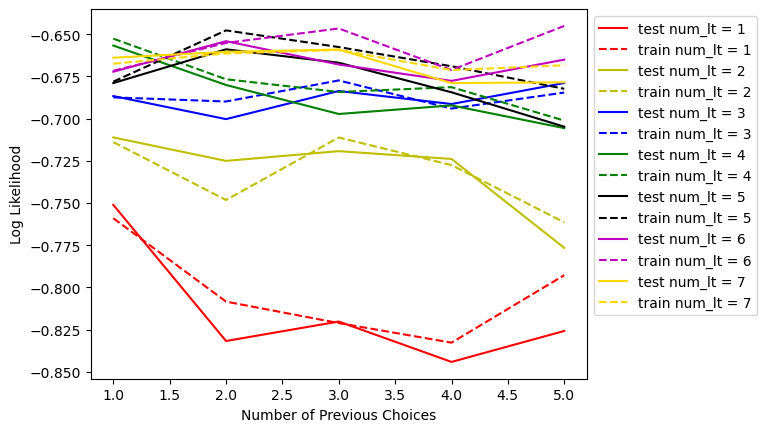

In [ ]:
for colid in range(num_numlt):
    x = range(1,num_np + 1)
    plt.plot(x, avg_test[:,colid]/test_sz, color = colors[colid],label = f"test num_lt = {colid + 1}")
    plt.plot(x, avg_train[:,colid]/train_sz, '--',color = colors[colid], label = f"train num_lt = {colid + 1}")
plt.ylabel("Log Likelihood")
plt.xlabel("Number of Previous Choices")
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

In [ ]:
# include ignore (worse than exluding ignore)
opt_np, opt_lt, avg_test, avg_train, std_test, std_train, train_sz, test_sz = GridSearch(file, False)


nprev 0 num_latent 1
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -603.0447409783865
test ll -60.71398735877999
Cross Validation 1 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -519.7518222943901
test ll -57.772548470763
Cross Validation 2 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -632.8314824590454
test ll -70.00411839521155
Cross Validation 3 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -426.9560886438859
test ll -46.3338866155792
Cross Validation 4 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -432.46003861940085
test ll -45.702574711545296
Cross Validation 5 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -465.4319977752559
test ll -50.16496461296555
Cross Validation 6 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -599.835527954728
test ll -63.56961624371536
Cross Validation 7 complete
Init 1 Complete
Init 2 Complete
Init 3 Complete
train ll -507.4

KeyboardInterrupt: 

# Visualization

In [ ]:
# Fit a model on all data
# Choose nprev = 2, num_latent = 3, exclude ignore
data = Dataloader_sess(file, nprev = 2, exig = True)
N = len(data)
K = 3 # number of latent states
D = data.shape[1] - 2 #number of GLM inputs (regressors)
C = 2
X = data[:,1:-1]
y = data[:,-1]
model = GLMHMM(N,D,C,K,observations='bernoulli') 
A_init,w_init,pi_init = model.generate_params() 
lls,A,w,pi0 = model.fit(y,X,A_init,w_init)

In [ ]:
# w:KxDxC
A, w, pi0

(array([[0.31840976, 0.65251665, 0.02907359],
        [0.0405617 , 0.85356822, 0.10587008],
        [0.58422167, 0.03284743, 0.3829309 ]]),
 array([[[ 0.        , -4.20102347],
         [ 0.        ,  4.03472903],
         [ 0.        ,  0.53846649],
         [ 0.        ,  0.97163876],
         [ 0.        ,  0.15843349]],
 
        [[ 0.        , -1.62054798],
         [ 0.        ,  2.74922005],
         [ 0.        ,  0.766548  ],
         [ 0.        ,  0.11249953],
         [ 0.        ,  0.11982947]],
 
        [[ 0.        , -3.89337454],
         [ 0.        ,  6.54638785],
         [ 0.        ,  0.55500815],
         [ 0.        ,  1.39277725],
         [ 0.        , -2.9377564 ]]]),
 None)

[[0.31840976 0.65251665 0.02907359]
 [0.0405617  0.85356822 0.10587008]
 [0.58422167 0.03284743 0.3829309 ]]


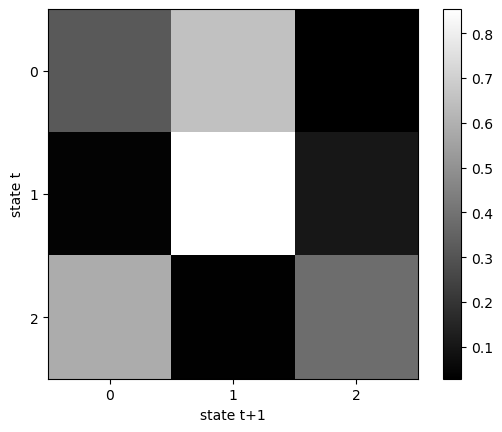

In [ ]:
# Transition matrix
print(A)
plt.imshow(A, cmap = 'gray')
plt.xlabel('state t+1')
plt.ylabel('state t')
plt.xticks(np.arange(A.shape[0]))
plt.yticks(np.arange(A.shape[0]))
plt.colorbar()

In [ ]:
# Weights
c1 = w[:,:,0]
c2 = w[:,:,1]
c1, c2 # c1 should be all zeros, so that it is bernoulli distribution

(array([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]]),
 array([[-4.20102347,  4.03472903,  0.53846649,  0.97163876,  0.15843349],
        [-1.62054798,  2.74922005,  0.766548  ,  0.11249953,  0.11982947],
        [-3.89337454,  6.54638785,  0.55500815,  1.39277725, -2.9377564 ]]))

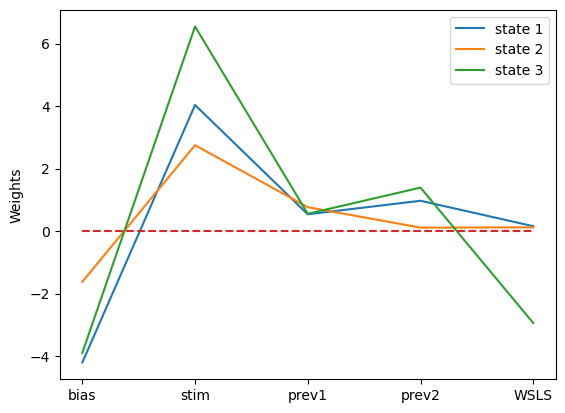

In [ ]:
weight = c2
state1 = weight[0,:]
state2 = weight[1,:]
state3 = weight[2,:]
x = np.arange(1, len(state1) + 1)
plt.plot(x, state1, label = 'state 1')
plt.plot(x, state2, label = 'state 2')
plt.plot(x, state3, label = 'state 3')
plt.plot(x, [0]*len(x), '--')
plt.xticks(x, labels = ['bias', 'stim','prev1','prev2','WSLS'])
plt.ylabel("Weights")
plt.legend()

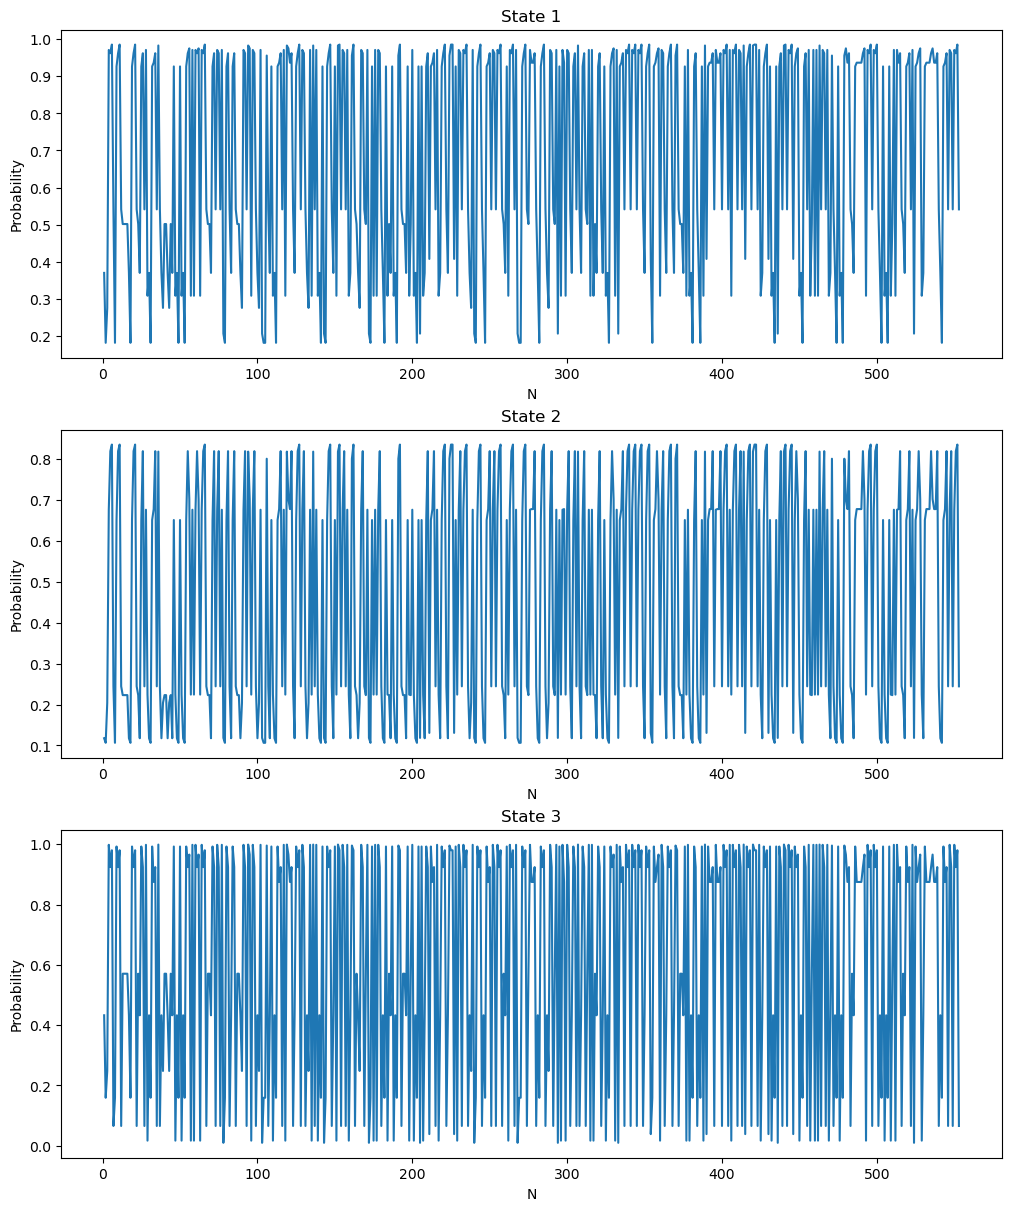

In [ ]:
# Emission Probability of class 1
fig, axs = plt.subplots(3, 1, figsize=(10, 12), constrained_layout=True)

for k in range(0, K):
    phi = np.exp(X@w[k,:,:])
    phi = np.divide(phi.T,np.sum(phi,axis=1)).T
    axs[k].set_title(f'State {k+1}')
    axs[k].plot(range(1, len(phi)+1), phi[:,0], label=f'state {k+1}')
    axs[k].set_xlabel('N')
    axs[k].set_ylabel('Probability')

# Shuffle the data

Compare the fitting of three kinds of data

(1) unshuffled data

(2) shuffle the rows of data. In other words, shuffle the time to break the continuity. 
    The relation between x and y doesn't change
    
(3) only shuffle the y, while keep x unchanged. 

In [ ]:
org_data = Dataloader_sess(file, nprev = 2, exig = True)

In [ ]:
A_orgs = []
A_ts = []
w_orgs = []
w_ts = []
for i in range(10):
    # Get X and y
    shuffled_indices = np.random.permutation(org_data.shape[0])
    shfl_time_data = org_data[shuffled_indices, :] # shuffle the rows of the matrix/shuffle the time
    shfl_y_data = np.hstack((org_data[:, :-1], org_data[shuffled_indices, -1:])) # only shuffle the y
    
    X_org = org_data[:,1:-1]
    y_org = org_data[:,-1]
    X_shf_t = shfl_time_data[:,1:-1]
    y_shf_t = shfl_time_data[:,-1]
    X_shf_y = shfl_y_data[:,1:-1]
    y_shf_y = shfl_y_data[:,-1]

    # Fit model for each pair of X and y
    A_init,w_init,pi_init = model.generate_params() 
    lls_org,A_org,w_org,_ = model.fit(y_org,X_org,A_init,w_init)
    ll_org = find_last_non_nan_elements(lls_org.reshape(1, -1))
    
    A_init,w_init,pi_init = model.generate_params() 
    lls_t,A_t,w_t,_ = model.fit(y_shf_t,X_shf_t,A_init,w_init)
    ll_t = find_last_non_nan_elements(lls_t.reshape(1, -1))
    
    A_init,w_init,pi_init = model.generate_params() 
    lls_y,_,_,_ = model.fit(y_shf_y,X_shf_y,A_init,w_init)
    ll_y = find_last_non_nan_elements(lls_y.reshape(1, -1))

    A_orgs.append(A_org)
    A_ts.append(A_t)
    w_orgs.append(w_org)
    w_ts.append(w_t)
    
    print(ll_org, ll_t, ll_y)

[-267.46098804] [-267.89676785] [-366.97626956]
[-274.78815677] [-269.55915712] [-371.81865053]
[-274.2089975] [-270.91451413] [-373.94980618]
[-275.00647552] [-268.7871618] [-374.73501314]
[-273.37647308] [-274.37735607] [-374.81313593]
[-267.03665309] [-274.92387584] [-372.23376567]
[-272.26132244] [-273.83573528] [-374.69420157]
[-272.06414702] [-266.59963589] [-378.56270664]
[-274.59458856] [-270.12174061] [-376.55514309]
[-274.80386914] [-268.99868881] [-380.30770508]


In [ ]:
A_orgs[0], A_ts[0]

(array([[8.98400509e-01, 9.83594914e-02, 3.23999970e-03],
        [1.50110672e-05, 4.56217891e-06, 9.99980427e-01],
        [2.04255422e-01, 1.63622894e-02, 7.79382289e-01]]),
 array([[6.55151445e-01, 2.45326717e-10, 3.44848555e-01],
        [5.71580664e-03, 9.58919925e-01, 3.53642681e-02],
        [3.04408254e-01, 1.61846425e-01, 5.33745321e-01]]))

In [ ]:
A_orgs[4], A_ts[4]

(array([[0.92529793, 0.01823017, 0.05647189],
        [0.46803024, 0.25686841, 0.27510135],
        [0.00501806, 0.41492136, 0.58006058]]),
 array([[0.55530795, 0.23650416, 0.20818789],
        [0.02938307, 0.47078181, 0.49983512],
        [0.04952553, 0.01238901, 0.93808546]]))